
# 卷积神经网络的应用

欢迎来到课程4的第二项作业！在此笔记本中，你将：

    实现模型构建所需的辅助函数
    使用TensorFlow实现功能全面的ConvNet

**完成此作业后，你将能够**：

    用TensorFlow构建和训练ConvNet解决分类问题

我们在这里假设你已经熟悉TensorFlow。如果不是，请先学习课程2第三周的TensorFlow教程（“改善深度神经网络”）。


## 1 TensorFlow模型

在上一项作业中，你使用numpy构建了辅助函数，以了解卷积神经网络背后的机制。实际上现在大多数深度学习的应用都是使用编程框架构建的，框架具有许多内置函数，你可以轻松地调用它们。

和之前一样，我们将从加载包开始。


In [7]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

运行以下单元格以加载要使用的“SIGNS”数据集。

In [8]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

SIGNS数据集是6个手势符号的图片集，这些符号表示从0到5的数字。

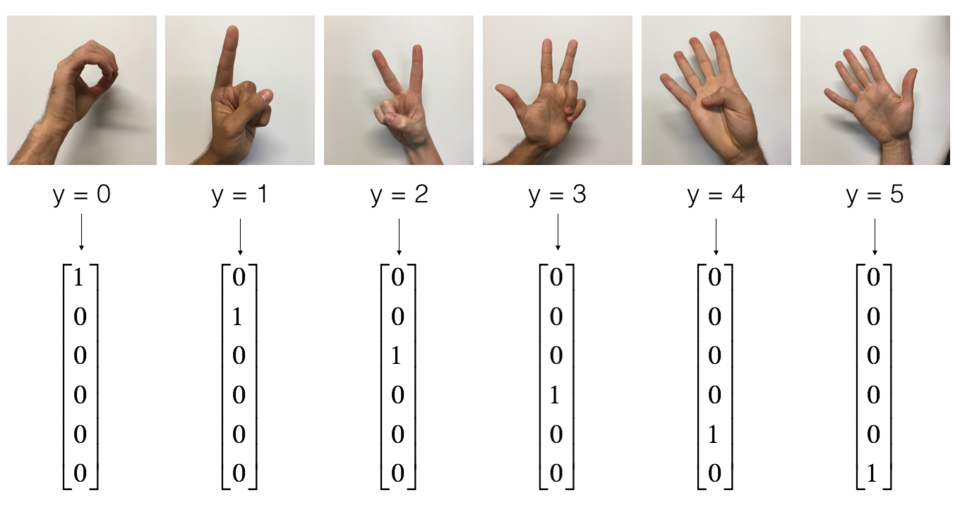

以下单元格将显示数据集中标记图像的示例。随时更改index的值，然后重新运行以查看不同的示例。

y = 2


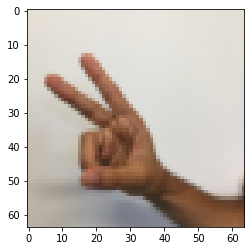

In [9]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))



在课程2中，你已经为此数据集构建了一个全连接的网络。但是由于这是图像数据集，因此应用ConvNet将更自然。

首先，让我们检查数据的维度。


In [10]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 1.1 创建占位符

TensorFlow需要为运行会话时输入的数据创建占位符。

**练习**：实现以下函数为输入图像X和输出Y创建占位符。暂时不用定义训练数据的数量。为此，你可以使用 "None" 作为批次大小，稍后灵活地选择它。因此，X的维度应为 [None, n_H0, n_W0, n_C0]，Y的尺寸应为 [None, n_y]。

In [14]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.compat.v1.placeholder(tf.float32,shape=(None,n_y))
    ### END CODE HERE ###
    
    return X, Y

In [17]:
tf.compat.v1.disable_eager_execution()

X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(None, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(None, 6), dtype=float32)


### 1.2 初始化参数

你将使用tf.contrib.layers.xavier_initializer（seed = 0）初始化权重/滤波器$W1$和$W2$。你无需担心偏差变量，因为TensorFlow函数可以处理偏差。还要注意你只会为conv2d函数初始化权重/滤波器，TensorFlow将自动初始化全连接部分的层。在本作业的后面，我们将详细讨论。

**练习**:实现initialize_parameters(),下面提供了每组过滤器的尺寸。

**提示**：在Tensorflow中初始化维度为[1,2,3,4]的参数$W$，使用：

In [26]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.compat.v1.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 =tf.compat.v1.get_variable('W1',[4,4,3,8],initializer=tf.initializers.GlorotUniform(seed = 0))
    W2 = tf.compat.v1.get_variable('W2',[2,2,8,16],initializer=tf.initializers.GlorotUniform(seed = 0))
    ### END CODE HERE ###
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [28]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.compat.v1.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [-0.05346771  0.18349849 -0.01215445  0.00138046  0.0012947  -0.02904211
 -0.11260509 -0.143055  ]
W2 = [-0.1713624   0.09527719 -0.0744766  -0.02245569  0.24450928 -0.06879854
  0.21546292 -0.08803296 -0.16513646 -0.19527972 -0.22957063  0.15745944
  0.13090086 -0.12304181 -0.05287278  0.03434092]


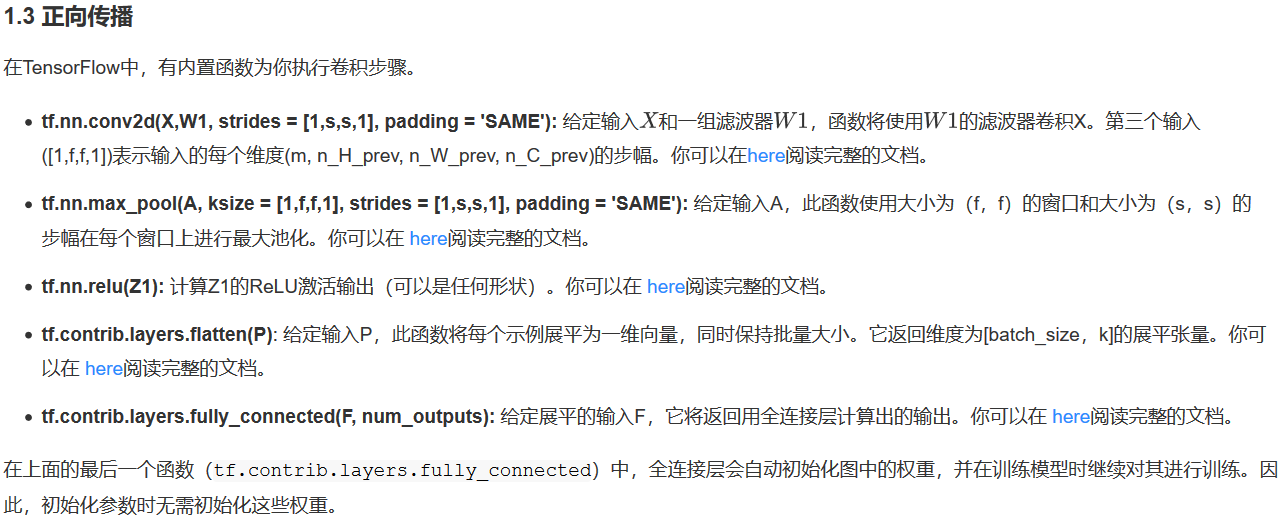

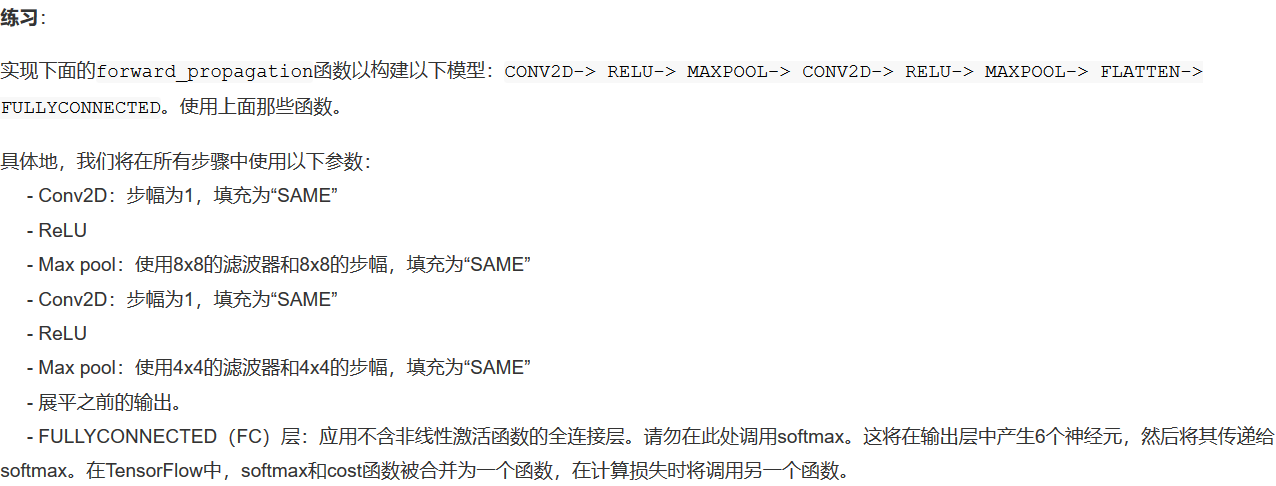

In [46]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.compat.v1.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.compat.v1.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.compat.v1.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.compat.v1.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.compat.v1.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.compat.v1.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.keras.layers.Flatten()(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
    Z3 = tf.keras.layers.Dense(P2, num_outputs = 6, activation_fn=None)
    ### END CODE HERE ###


    return Z3

In [47]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

TypeError: ('Keyword argument not understood:', 'num_outputs')